In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import base64

tqdm.pandas()
from wekeypedia import WikipediaPage as Page

In [2]:
name = 'Elke Mackenzie'
dead_name = 'SXZhbg=='
page_name = 'Ivan_Mackenzie_Lamb'
co_date = None

In [3]:
# Parameters
name = "Andr\xe9a Furet"
dead_name = "QWxleGFuZHJl"
page_name = "Andr\xe9a_Furet"
co_date = "2019-06-01"


In [4]:
def format_revid_index(revid, page):
    return f'<a href="https://fr.wikipedia.org/w/index.php?title={page}&diff=prev&oldid={revid}">{revid}</a>'

# qui sont personnes qui énoncent le deadname dans l'article ?

## article

In [5]:
page = Page(page_name, lang='fr')

In [6]:
revisions = (
    pd
    .DataFrame
    .from_records(page.get_revisions())
    .set_index('revid')
)

revisions

,parentid,user,userid,timestamp,size,sha1,contentformat,contentmodel,comment,*,anon
revid,,,,,,,,,,,
213316157,213116201,Victoire F.,1719539,2024-03-13T13:03:39Z,16524,fe6a2f3ee41409dfff55c73d845cd502bec0d16d,text/x-wiki,wikitext,Ajout rapide de {{palette}} : + Transidentité ...,{{Semi-protection longue}}\n{{Voir homonymes|F...,NaN
213116201,213116127,TwoWings,28903,2024-03-06T17:24:35Z,16486,78694252f4cfd9a58309ce3f9a3eed3dd0f400e1,text/x-wiki,wikitext,maladroit,{{Semi-protection longue}}\n{{Voir homonymes|F...,NaN
213116127,213112685,DarkVador79-UA,4553277,2024-03-06T17:20:55Z,16475,dcbeb02c588243344ea13546d1af22ff2094b144,text/x-wiki,wikitext,/* Carrière */,{{Semi-protection longue}}\n{{Voir homonymes|F...,NaN
213112685,213112419,Cymbella,316223,2024-03-06T15:00:27Z,16463,6dde12a7c19e3b35c1ada7e9710bc4bc0bbd1000,text/x-wiki,wikitext,/* Carrière */ formulation moins ambiguë,{{Semi-protection longue}}\n{{Voir homonymes|F...,NaN
213112419,213112061,Sherwood6,4022033,2024-03-06T14:49:56Z,16462,58af505b6de17df745ca7195ff1c6e3f3209019f,text/x-wiki,wikitext,Annulation de la [[Special:Diff/213112061|modi...,{{Semi-protection longue}}\n{{Voir homonymes|F...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
187698498,187698477,CuriousReader,377761,2021-11-04T07:53:46Z,7545,a5edab797b76049e9ea16bcedfa344f32ffcc2b4,text/x-wiki,wikitext,/* Carrière */ ajout,{{Voir homonymes|Furet (homonymie)}}\n{{Infobo...,NaN
187698477,187698235,CuriousReader,377761,2021-11-04T07:52:42Z,7543,5c635618ea2aa5e8c5c45149ede212b6fd14eb25,text/x-wiki,wikitext,/* Carrière */ correction,{{Voir homonymes|Furet (homonymie)}}\n{{Infobo...,NaN
187698235,187687803,CuriousReader,377761,2021-11-04T07:38:00Z,7546,1302775668cba51500875d735daa91ef36a23a5d,text/x-wiki,wikitext,/* Liens externes */ ajout paragraphe,{{Voir homonymes|Furet (homonymie)}}\n{{Infobo...,NaN


In [7]:
revisions.to_csv(f'../data/page-revisions/{page_name.lower()}.csv')

In [8]:
def decode(string):
    return base64.b64decode(string).decode("utf-8")

<Axes: xlabel='date'>

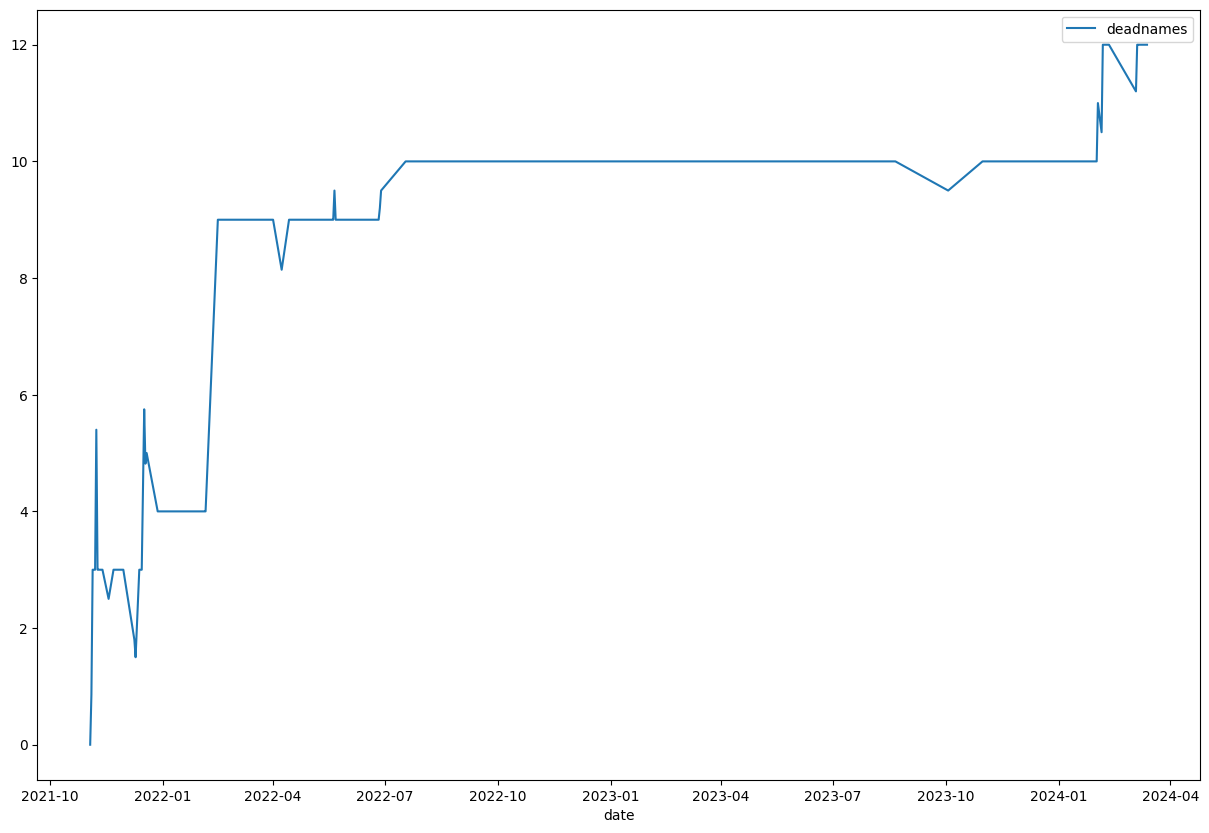

In [9]:
(
    revisions
    .assign(
        deadnames = lambda df: df['*'].apply(lambda x: str(x).lower().count(decode(dead_name).lower()))
    )
    #.reset_index()
    [['timestamp', 'deadnames']]
    .assign(
        date = lambda df: pd.to_datetime(df.timestamp).dt.date
    )
    .groupby('date')
    .agg({'deadnames': 'mean'})
    .plot
    .line(
        figsize=(15,10)
    )
)

In [10]:
def get_diff(revid):
    return page.get_diff(revid)

diffs = revisions.reset_index().revid.progress_apply(lambda x: page.extract_plusminus(get_diff(x))['added'] )

#diffs

100%|██████████| 242/242 [01:20<00:00,  3.02it/s]


### depuis le coming out

In [11]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # on ne garde que les contributions après son coming out
    .pipe(lambda df: df.query(f'timestamp >= "{co_date}"') if co_date != None else df)
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Evynrhud          14
Eliedion           8
Cymbella           7
JohnNewton8        6
Lewisiscrazy       6
Salebot            5
Sherwood6          4
Le chat perché     4
ManuRoquette       3
Kirham             3
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [12]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # début du sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

user
Sherwood6          4
Andreafuret1106    0
Cymbella           0
DarkVador79-UA     0
JohnNewton8        0
Machaonix          0
Msbbb              0
Shev123            0
TwoWings           0
Victoire F.        0
Name: deadname_count, dtype: int64

In [13]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # début du sondage
    .query('timestamp >= "2024-01-15"')
    .query('deadname_count > 0')
    [['user', 'deadname_count', 'timestamp']]
    .style
    .format_index(lambda x: format_revid_index(x, page_name))
)

,user,deadname_count,timestamp
revid,,,
213043964,Sherwood6,4,2024-03-04T15:36:51Z
212190917,Lewisiscrazy,6,2024-02-05T22:40:00Z
212088329,Eliedion,2,2024-02-02T17:16:30Z


## Discussions

In [14]:
talk = Page(f'Discussion:{page_name}', lang='fr')

In [15]:
talk_revisions = (
    pd
    .DataFrame
    .from_records(talk.get_revisions_list())
    .assign(
        diff = lambda df: df.revid.progress_apply(lambda x: talk.get_diff(x)),
        deleted = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['deleted']),
        added = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['added']),
    )
    .set_index('revid')
)

#talk_revisions

100%|██████████| 145/145 [00:50<00:00,  2.88it/s]


In [16]:
talk_revisions.to_csv(f'../data/page-diffs/discussion:{page_name.lower()}.csv')

### depuis le coming out

In [17]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # on ne garde que les contributions après son coming out
    #.query('timestamp >= "2013-08-22"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Evynrhud                                  10
Eliedion                                   8
JohnNewton8                                8
ManuRoquette                               8
Sherwood6                                  7
TwoWings                                   4
Scriptance                                 2
Nattes à chat                              1
Cymbella                                   1
2A01:E34:EC21:C220:705E:43A2:413A:F3EA     0
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [18]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Sherwood6        7
Anne Daemon      0
Eliedion         0
JohnNewton8      0
Kvardek du       0
Pic-Sou          0
Shev123          0
Vache-crapaud    0
Name: deadname_count, dtype: int64

In [19]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .query('deadname_count > 0')
    [['user', 'deadname_count', 'timestamp']]
    .style
    .format_index(lambda x : format_revid_index(x, f'Discussion:{page_name}'))
)

,user,deadname_count,timestamp
revid,,,
213122402,Sherwood6,1,2024-03-06T22:17:24Z
213115664,Sherwood6,2,2024-03-06T16:59:36Z
213075687,Sherwood6,2,2024-03-05T11:55:45Z
213071959,Sherwood6,2,2024-03-05T09:44:46Z


In [20]:
len(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .query('deadname_count > 0')
    [['user', 'deadname_count']]
)

4